In [1]:
from IMPA.dataset.data_loader import CellDataLoader
from IMPA.solver import IMPAmodule
from omegaconf import OmegaConf
import matplotlib.pyplot as plt
from tqdm import tqdm
import matplotlib.pyplot as plt
from pathlib import Path
import numpy as np
import os
import torch
from tqdm import tqdm
import pandas as pd
import seaborn as sns
from skimage import io, color, filters, measure
import pickle as pkl
import yaml
import scanpy as sc

import sys
sys.path.insert(0, "/home/icb/alessandro.palma/environment/IMPA/IMPA/experiments/measure_metrics")
from compute_metrics import *

from rdkit import Chem
from rdkit.Chem import AllChem, DataStructs
from itertools import combinations
from pathlib import Path

An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


# Utility functions 

In [2]:
def initialize_model(yaml_config, dest_dir):
    args_rdkit = OmegaConf.create(yaml_config)
    dataloader_rdkit = CellDataLoader(args_rdkit)
    solver_rdkit = IMPAmodule(args_rdkit, dest_dir, dataloader_rdkit)
    return solver_rdkit

class Args:
    def __init__(self, dictionary):
        self.__dict__ = dictionary

    def __getattr__(self, key):
        if key in self.__dict__:
            return self.__dict__[key]
        else:
            raise AttributeError(f"'DictToObject' object has no attribute '{key}'")

    def __call__(self, key):
        return self.__getattr__(key)


def t2np(t, batch_dim=False):
    return ((t.permute(0, 2, 3, 1) + 1) / 2).clamp(0, 1).cpu().numpy()


def plot_n_images(images, n_to_plot, channel=None, size=((1.5, 1.5))):
    for i, img in enumerate(images):
        plt.figure(figsize=size)
        if channel == None:
            plt.imshow(img)
        else:
            plt.imshow(img[:,:,channel],"grey")
        plt.axis("off")
        plt.grid("off")
        plt.show()
        if i == n_to_plot:
            break

def transform_by_emb(solver, dataloader, y, n_average, args):
    """
    Transform images in a dataloader using a solver for a specific drug ID.

    Parameters:
        solver: The solver object used for transformation.
        dataloader: The dataloader containing images to be transformed.
        n_average (int): Number of times to average random noise vectors.
        drug_id (str): The ID of the drug for transformation.
        args: Arguments object containing additional parameters.

    Returns:
        tuple: A tuple containing two NumPy arrays representing controls and transformed images.
    """
    controls = []
    transformed = []
    y = y.unsqueeze(0)
    with torch.no_grad():
        for batch in tqdm(dataloader.train_dataloader()):
            X_ctr = batch["X"][0]
            z = torch.ones(X_ctr.shape[0], n_average, args.z_dimension).cuda().mean(1)
            # z = torch.randn(X_ctr.shape[0], n_average, args.z_dimension).cuda().quantile(0.75,1)
            
            # Perturbation ID 
            y_emb = y.repeat((z.shape[0], 1)).cuda()
            y_emb = torch.cat([y_emb, z], dim=1)
            y_emb = solver.nets.mapping_network(y_emb) 
            
            _, X_generated = solver.nets.generator(X_ctr, y_emb)
            transformed.append(t2np(X_generated.detach().cpu()))
            controls.append(t2np(X_ctr.detach().cpu()))
            break
    return np.concatenate(controls, axis=0), np.concatenate(transformed, axis=0)

# Import models

In [3]:
bbbbc021_embeddings = pd.read_csv("/home/icb/alessandro.palma/environment/IMPA/IMPA/embeddings/csv/emb_fp_all.csv", index_col=0)

bbbc021_index = pd.read_csv("/lustre/groups/ml01/workspace/alessandro.palma/imCPA_official/data/bbbc021_unannotated/processed/bbbc021_unannotated_large/metadata/bbbc021_unannotated_large_subset.csv",
                           index_col=0)

In [4]:
unique_cpds = np.unique(bbbc021_index.CPD_NAME)

In [5]:
bbbbc021_embeddings = bbbbc021_embeddings.loc[bbbbc021_embeddings.index.isin(unique_cpds)]

Get ood drugs 

In [6]:
ood_drugs = ["taxol", 
             "ALLN", 
             "bryostatin", 
             "simvastatin", 
             "MG-132", 
             "methotrexate", 
             "colchicine", 
             "cytochalasin B", 
             "AZ258", 
             "cisplatin"]

In [7]:
ood_drug_embeddings = bbbbc021_embeddings.loc[ood_drugs]

In [8]:
path_to_configs = Path("/home/icb/alessandro.palma/environment/IMPA/IMPA/config_hydra/config")

with open(path_to_configs / 'REBUTTAL_bbbc021_large_all_subset.yaml', 'r') as IMPA_bbbc021:
    # Load YAML data using safe_load() from the file
    yaml_IMPA_bbbc021 = yaml.safe_load(IMPA_bbbc021)

dest_dir = "/home/icb/alessandro.palma/environment/IMPA/IMPA/project_folder/experiments/20240902_9dede8fc-6615-4f23-8299-bdd7bb52d920_bbbc021_unannotated_large_subset"

args = OmegaConf.create(yaml_IMPA_bbbc021)
dataloader = CellDataLoader(args)
IMPA_bbbc021 = initialize_model(yaml_IMPA_bbbc021, dest_dir)

IMPA_bbbc021._load_checkpoint(200)

Number of parameters in generator: 24318595
Number of parameters in style_encoder: 16164480
Number of parameters in discriminator: 14308952
Number of parameters in mapping_network: 66624
Initializing embedding_matrix...
Initializing generator...
Initializing style_encoder...
Initializing discriminator...
Initializing mapping_network...
IMPAmodule(
  (embedding_matrix): Embedding(24, 1024)
  (generator): DataParallel(
    (module): Generator(
      (from_rgb): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (encode): ModuleList(
        (0): ResBlk(
          (actv): LeakyReLU(negative_slope=0.2)
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (norm1): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
          (norm2): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=Fals

# Check embeddings

In [9]:
learnt_embs = []
drug_labs = []

In [10]:
for emb in bbbbc021_embeddings.index:
    learnt_embs.append(torch.tensor(bbbbc021_embeddings.loc[emb]))
    drug_labs.append(emb)

In [11]:
learnt_embs = torch.stack(learnt_embs, dim=0).cuda()

In [12]:
with torch.no_grad():
    z = torch.zeros(1, 1, args.z_dimension).cuda().mean(1)
    z = z.repeat((learnt_embs.shape[0], 1)).cuda()
    y_emb = torch.cat([learnt_embs, z], dim=1)
    y_emb = IMPA_bbbc021.nets.mapping_network(y_emb).cpu()

In [13]:
obs = pd.DataFrame({"Drug name": drug_labs, 
       "State": ["Unseen" if drug in ood_drugs else "Seen" for drug in drug_labs]
      })

In [14]:
adata = sc.AnnData(X=y_emb.numpy(), 
                  obs=obs)

/home/icb/alessandro.palma/miniconda3/envs/IMPA_try/lib/python3.9/site-packages/anndata/_core/anndata.py:183: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [15]:
sc.tl.pca(adata)

/home/icb/alessandro.palma/miniconda3/envs/IMPA_try/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


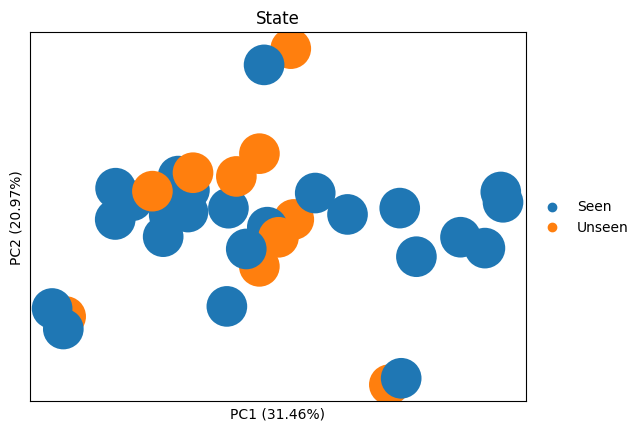

In [16]:
sc.pl.pca(adata, color="State", annotate_var_explained=True)

In [17]:
sc.pp.neighbors(adata)

In [18]:
sc.tl.umap(adata)

/home/icb/alessandro.palma/miniconda3/envs/IMPA_try/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


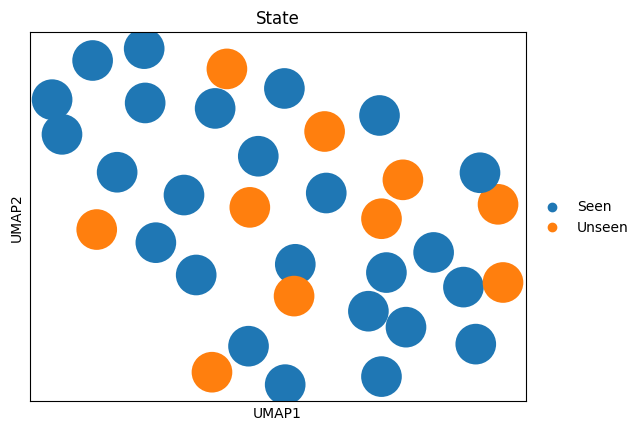

In [19]:
sc.pl.umap(adata, color="State")

## Annotate the plot

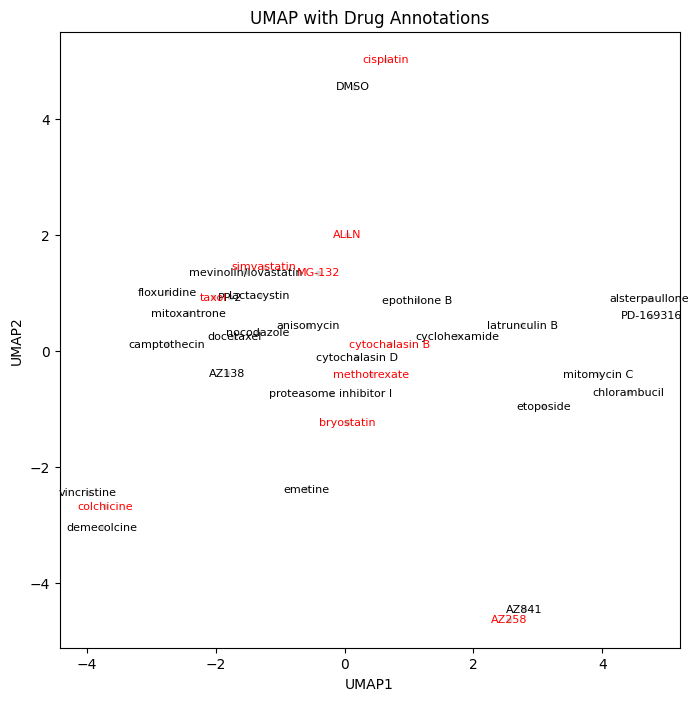

In [20]:
umap_coords = adata.obsm['X_pca']

# Annotation names (drug names) are stored in a specific column of adata.obs
annotation_names = adata.obs['Drug name']  # Replace 'drug_names' with your column name

# Create the UMAP plot
plt.figure(figsize=(8, 8))
plt.scatter(umap_coords[:, 0], umap_coords[:, 1], s=10, c='lightgray')  # Plot the UMAP points

# Annotate the UMAP with drug names
for i, name in enumerate(annotation_names):
    col = "black" if name not in ood_drugs else "red"
    plt.text(umap_coords[i, 0], umap_coords[i, 1], name, fontsize=8, ha='center', va='center', color=col)

# Optionally, you can add axis labels and a title
plt.xlabel('UMAP1')
plt.ylabel('UMAP2')
plt.title('UMAP with Drug Annotations')

# Show the plot
plt.show()

## Get one real image per drug 

In [21]:
folder = Path("/lustre/groups/ml01/workspace/alessandro.palma/imCPA_official/data/bbbc021_unannotated/processed/bbbc021_unannotated_large")

In [24]:
leavout_plates = {
         "DMSO": ["Week1_22401"],
         "PD-150606": ["Week9_39301"],
         "cathepsin inhibitor I":["Week9_39221"],
         "colchicine": ["Week1_22401","Week1_22123"],
         "cytochalasin B": ["Week1_22161","Week1_22123"],
         "doxorubicin": ["Week1_22361"],
         "epothilone B": ["Week1_22361"],
         "latrunculin B": ["Week1_22381","Week1_22401"], 
         "nocodazole": ["Week1_22123","Week1_22381"]}

In [25]:
idxs = []
drug2image = {}
drug2week = {}

for drug in np.unique(bbbc021_index.CPD_NAME):
    bbbc021_index_loc = bbbc021_index.loc[bbbc021_index.CPD_NAME==drug]
    batch  = np.array(bbbc021_index_loc.BATCH)
    if drug in leavout_plates:
        bbbc021_index_loc = bbbc021_index.loc[~bbbc021_index.BATCH.isin(leavout_plates[drug])]
    # Choose random obs 
    m = 0
    v = 0
    while m < 20 or v < 200:
        choice = np.random.choice(list(bbbc021_index_loc.index))
        filename = bbbc021_index.loc[choice].SAMPLE_KEY
        filename_split = filename.split("_")
        file = np.load(folder / filename_split[0] / filename_split[1] / ('_'.join(filename_split[2:])+".npy"))
        m = file.mean()
        v = file.var()
    
    drug2image[drug] = file
    drug2week[drug] = bbbc021_index_loc.loc[choice].BATCH
    
# bbbc021_index_no_dup = bbbc021_index.loc[idxs]
# bbbc021_index_no_dup = bbbc021_index.loc[bbbc021_index.CPD_NAME=="taxol"]
# file2drug = list(zip(bbbc021_index_no_dup.SAMPLE_KEY, bbbc021_index_no_dup.ANNOT))
# drug2week = dict(zip(bbbc021_index_no_dup.ANNOT, bbbc021_index_no_dup.BATCH))

In [26]:
# for filename, drug in file2drug:
#     filename_split = filename.split("_")
#     file = np.load(folder / filename_split[0] / filename_split[1] / ('_'.join(filename_split[2:])+".npy"))
#     drug2image[drug] = file

ALLN
Week2_24121
57.565653483072914
3008.06111930766


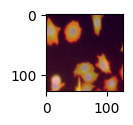

AZ138
Week10_40119
21.552205403645832
1783.7991137885385


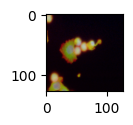

AZ258
Week4_27801
50.143656412760414
2118.9390592868954


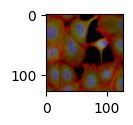

AZ841
Week3_25441
104.23250325520833
2331.000670426422


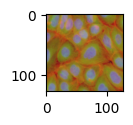

DMSO
Week5_29341
78.06675211588542
3043.5260413880983


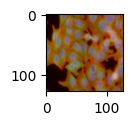

MG-132
Week2_24381
36.3416748046875
586.8264549424251


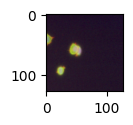

PD-169316
Week7_34661
104.56022135416667
1955.4259795082937


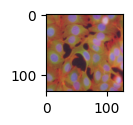

PP-2
Week8_38341
80.84315999348958
2556.9449446693893


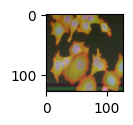

alsterpaullone
Week7_34661
107.09706624348958
2019.8458637889062


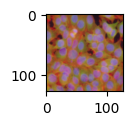

anisomycin
Week4_27481
43.50286865234375
950.2411213281254


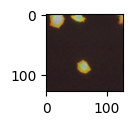

bryostatin
Week7_34661
73.57444254557292
3280.8942385808464


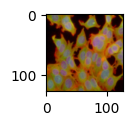

camptothecin
Week8_38203
94.62086995442708
2337.541827628596


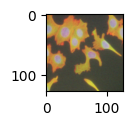

chlorambucil
Week3_25681
117.28818766276042
1985.291602005147


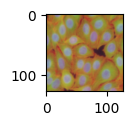

cisplatin
Week3_25721
96.8668212890625
2278.605310305953


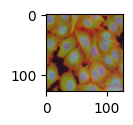

colchicine
Week1_22141
90.73345947265625
4403.001893159002


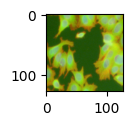

cyclohexamide
Week4_27801
40.712666829427086
2561.539896517578


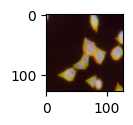

cytochalasin B
Week5_29341
22.5506591796875
2159.1976289600134


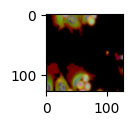

cytochalasin D
Week2_24141
27.67572021484375
2233.6849020284913


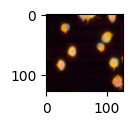

demecolcine
Week3_25681
33.490498860677086
2361.600495665851


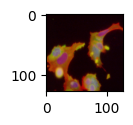

docetaxel
Week7_34381
39.404744466145836
1909.8930666827493


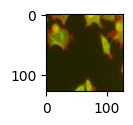

emetine
Week3_25701
38.9503173828125
2828.0193008432784


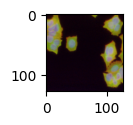

epothilone B
Week8_38241
104.48569742838542
3598.8281645770708


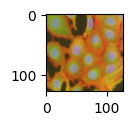

etoposide
Week3_25421
116.38651529947917
2206.8726192696226


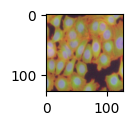

floxuridine
Week9_39282
56.158976236979164
395.11160806649264


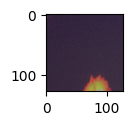

lactacystin
Week6_31661
60.095906575520836
2537.035967944397


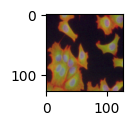

latrunculin B
Week3_25721
101.4942626953125
1914.71359013021


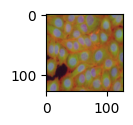

methotrexate
Week2_24121
80.83376057942708
3601.9760469094745


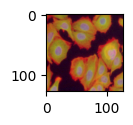

mevinolin/lovastatin
Week9_39221
71.45579020182292
3010.4319647645784


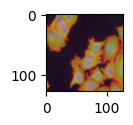

mitomycin C
Week4_27821
107.72996012369792
2591.9921215967174


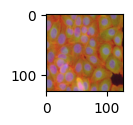

mitoxantrone
Week9_39283
23.395121256510418
2072.4962839778095


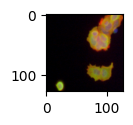

nocodazole
Week10_40119
21.552205403645832
1783.7991137885385


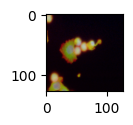

proteasome inhibitor I
Week7_34341
35.499064127604164
2199.6822501007055


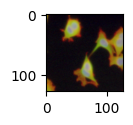

simvastatin
Week9_39283
42.683492024739586
2460.443503528419


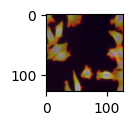

taxol
Week10_40115
21.134195963541668
1523.0769214563904


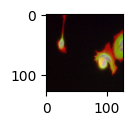

vincristine
Week3_25421
48.493937174479164
3409.2436155858973


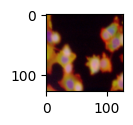

In [27]:
for drug in drug2image:
    print(drug)
    print(drug2week[drug])
    print(drug2image[drug].mean())
    print(drug2image[drug].var())
    plt.figure(figsize=(1,1))
    plt.imshow(drug2image[drug])
    plt.show()

## Transform images 

In [28]:
drugs = {}
controls = {}

for drug in ood_drugs:
    emb_drug = torch.Tensor(ood_drug_embeddings.loc[drug])
    control, transformed = transform_by_emb(IMPA_bbbc021, dataloader, emb_drug, 100, args)
    drugs[drug] = transformed
    controls[drug] = control

  0%|          | 0/593 [00:01<?, ?it/s]


taxol
DMSOs


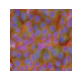

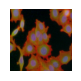

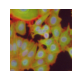

Transformed


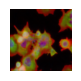

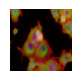

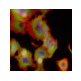

Real


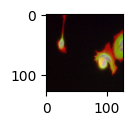

ALLN
DMSOs


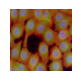

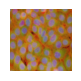

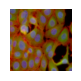

Transformed


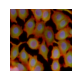

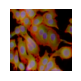

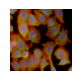

Real


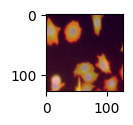

bryostatin
DMSOs


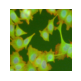

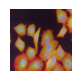

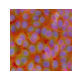

Transformed


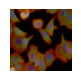

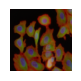

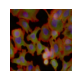

Real


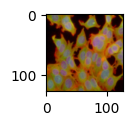

simvastatin
DMSOs


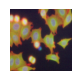

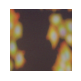

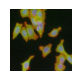

Transformed


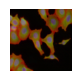

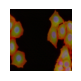

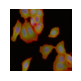

Real


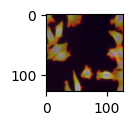

MG-132
DMSOs


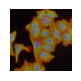

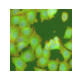

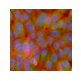

Transformed


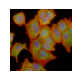

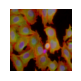

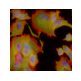

Real


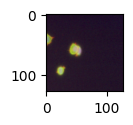

methotrexate
DMSOs


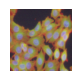

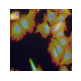

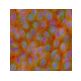

Transformed


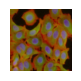

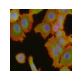

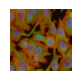

Real


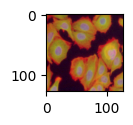

colchicine
DMSOs


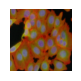

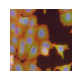

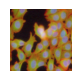

Transformed


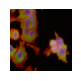

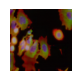

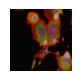

Real


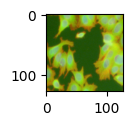

cytochalasin B
DMSOs


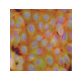

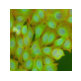

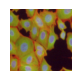

Transformed


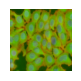

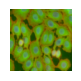

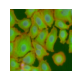

Real


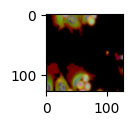

AZ258
DMSOs


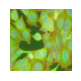

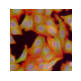

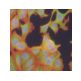

Transformed


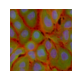

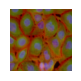

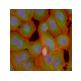

Real


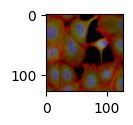

cisplatin
DMSOs


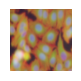

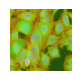

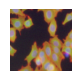

Transformed


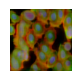

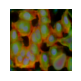

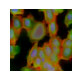

Real


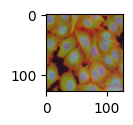

In [29]:
for drug in drugs:
    print(drug)
    print("DMSOs")
    plot_n_images(controls[drug], 2, [0,1,2], (0.8,0.8))
    # plot_n_images(controls[drug], 5, [0,1,2], (0.8,0.8))
    print("Transformed")
    plot_n_images(drugs[drug], 2, [0,1,2], (0.8,0.8))
    print("Real")
    plt.figure(figsize=(1,1))
    plt.imshow(drug2image[drug])
    plt.show()

## Check phenotypes in the UMAP

In [30]:
import matplotlib.image as mpimg
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

In [31]:
exclude = ["aphidicolin"]

In [32]:
def annotate_images(ax, x, y, img):
    imagebox = OffsetImage(img, zoom=0.15)  # Adjust zoom as necessary
    ab = AnnotationBbox(imagebox, (x, y), frameon=False)
    ax.add_artist(ab)

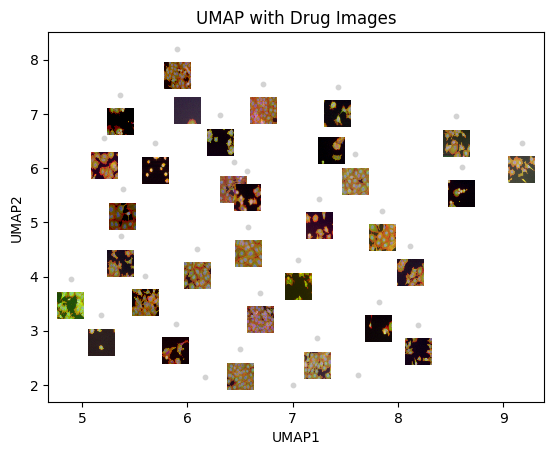

In [33]:
# Create the UMAP plot
fig, ax = plt.subplots()
ax.scatter(umap_coords[:, 0], umap_coords[:, 1], s=10, c='lightgray')  # Plot the UMAP points

# Annotate UMAP with images
for i, drug in enumerate(drug2image.keys()):
    if drug not in exclude:
        annotate_images(ax, umap_coords[i, 0], umap_coords[i, 1] - 0.5, drug2image[drug])
    # plt.imshow(drug2image[drug], extent=(umap_coords[i, 0] - 0.5, umap_coords[i, 0] + 0.5, 
    #                         umap_coords[i, 1] - 0.5, umap_coords[i, 1] + 0.5), aspect='auto')

# Optionally, you can add axis labels and a title
plt.xlabel('UMAP1')
plt.ylabel('UMAP2')
plt.title('UMAP with Drug Images')

# Show the plot
plt.show()

## Plot drug by choice

In [34]:
ood_drugs

['taxol',
 'ALLN',
 'bryostatin',
 'simvastatin',
 'MG-132',
 'methotrexate',
 'colchicine',
 'cytochalasin B',
 'AZ258',
 'cisplatin']

Week3_25681


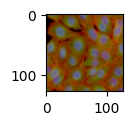

Week3_25721


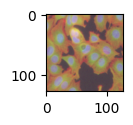

Week3_25701


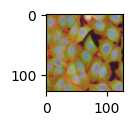

Week3_25701


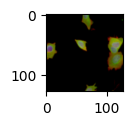

Week3_25721


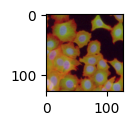

Week3_25721


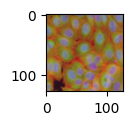

Week3_25721


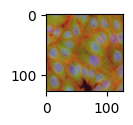

Week3_25721


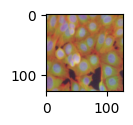

Week3_25681


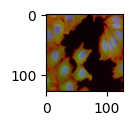

Week3_25701


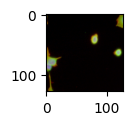

Week3_25721


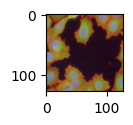

Week3_25721


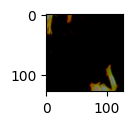

Week3_25701


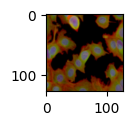

Week3_25701


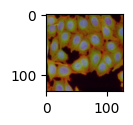

Week3_25721


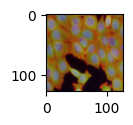

Week3_25701


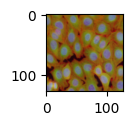

Week3_25701


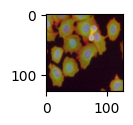

Week3_25701


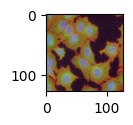

Week3_25721


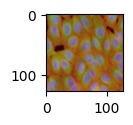

Week3_25721


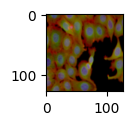

Week3_25681


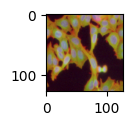

Week3_25701


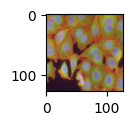

Week3_25721


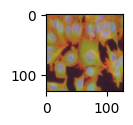

Week3_25681


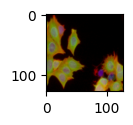

Week3_25721


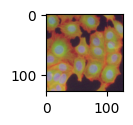

Week3_25701


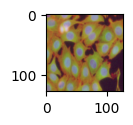

Week3_25681


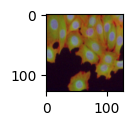

Week3_25681


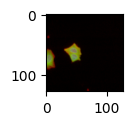

Week3_25681


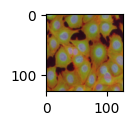

Week3_25681


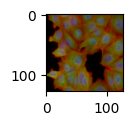

Week3_25721


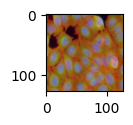

Week3_25681


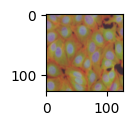

Week3_25701


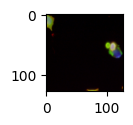

Week3_25721


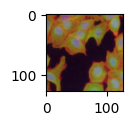

Week3_25701


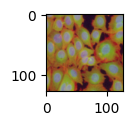

Week3_25681


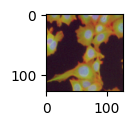

Week3_25721


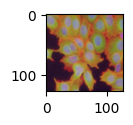

Week3_25681


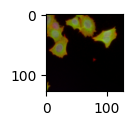

Week3_25681


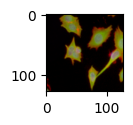

Week3_25701


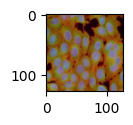

Week3_25681


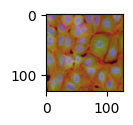

Week3_25681


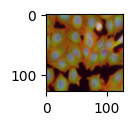

Week3_25681


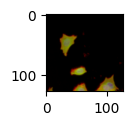

Week3_25701


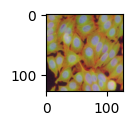

Week3_25701


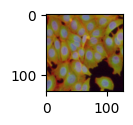

Week3_25701


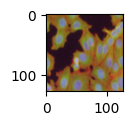

Week3_25721


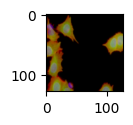

Week3_25681


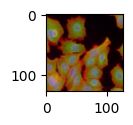

Week3_25681


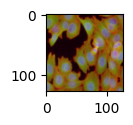

Week3_25701


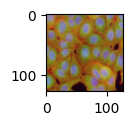

Week3_25721


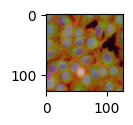

Week3_25681


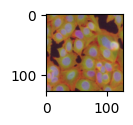

Week3_25701


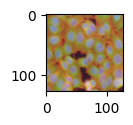

Week3_25701


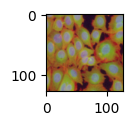

Week3_25701


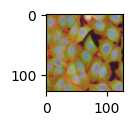

Week3_25721


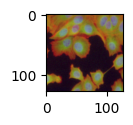

Week3_25721


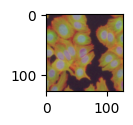

Week3_25681


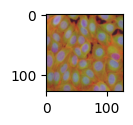

Week3_25721


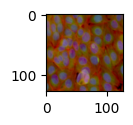

Week3_25681


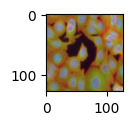

Week3_25721


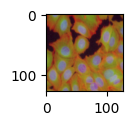

Week3_25721


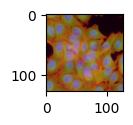

Week3_25681


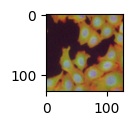

Week3_25721


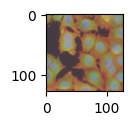

Week3_25721


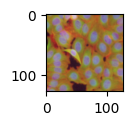

Week3_25721


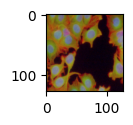

Week3_25721


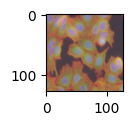

Week3_25721


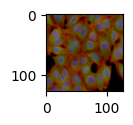

Week3_25681


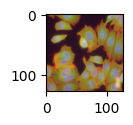

Week3_25681


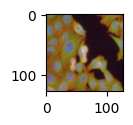

Week3_25721


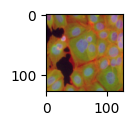

Week3_25721


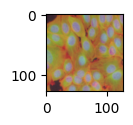

Week3_25681


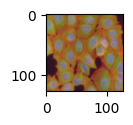

Week3_25681


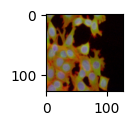

Week3_25681


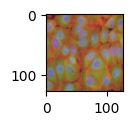

Week3_25681


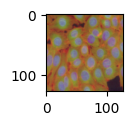

Week3_25721


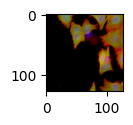

Week3_25721


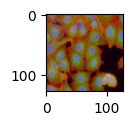

Week3_25701


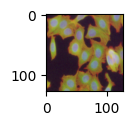

Week3_25681


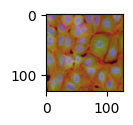

Week3_25721


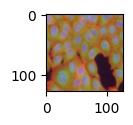

Week3_25681


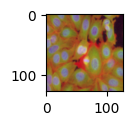

Week3_25701


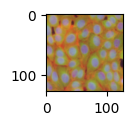

Week3_25681


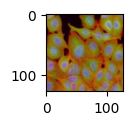

Week3_25681


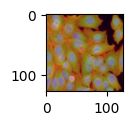

Week3_25721


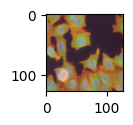

Week3_25721


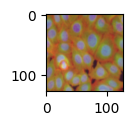

Week3_25701


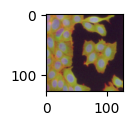

Week3_25681


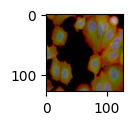

Week3_25721


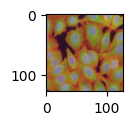

Week3_25701


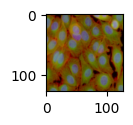

Week3_25721


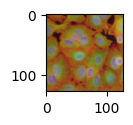

Week3_25681


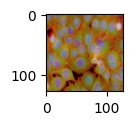

Week3_25721


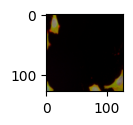

Week3_25681


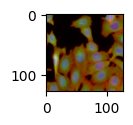

Week3_25681


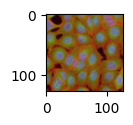

Week3_25721


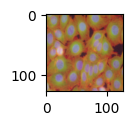

Week3_25721


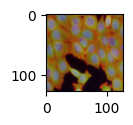

Week3_25681


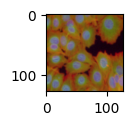

Week3_25701


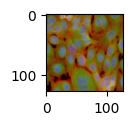

In [35]:
def plot_drug(df, drug, n):
    df_loc = df.loc[df.CPD_NAME==drug]
    if drug in leavout_plates:
        df_loc = df_loc.loc[~df_loc.BATCH.isin(leavout_plates[drug])]
    c = 0
    while c < n:
        choice = np.random.choice(list(df_loc.index))
        print(df_loc.loc[choice].BATCH)
        filename = df_loc.loc[choice].SAMPLE_KEY
        filename_split = filename.split("_")
        file = np.load(folder / filename_split[0] / filename_split[1] / ('_'.join(filename_split[2:])+".npy"))
        plt.figure(figsize=(1,1))
        plt.imshow(file)
        plt.show()
        c+=1

plot_drug(bbbc021_index, "cisplatin", 100)

Transformed


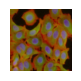

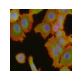

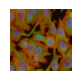

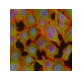

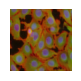

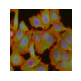

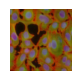

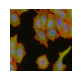

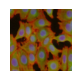

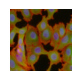

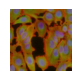

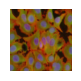

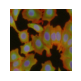

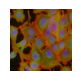

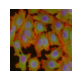

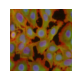

Real


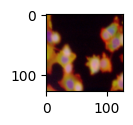

In [36]:
print("Transformed")
plot_n_images(drugs["methotrexate"], 100, [0,1,2], (0.8,0.8))
print("Real")
plt.figure(figsize=(1,1))
plt.imshow(drug2image[drug])
plt.show()

## Do the plots from before 

In [37]:
def compute_tanimoto_distance_from_df(df):
    """
    Computes Tanimoto distance between all pairs of SMILES strings in a DataFrame.

    Parameters:
    - df: DataFrame with SMILES strings in a column.

    Returns:
    - distances_df: DataFrame containing Tanimoto distances between all pairs of SMILES strings.
    """
    # Convert SMILES strings to RDKit Mol objects
    mols = [Chem.MolFromSmiles(smiles) for smiles in df['SMILES']]

    # Calculate fingerprints for each molecule
    fps = [AllChem.GetMorganFingerprint(mol, 2) for mol in mols]

    # Compute Tanimoto distance between all pairs of fingerprints
    distances = []

    similarity_df = pd.DataFrame(index=df.index, columns=df.index)
    for i, j in combinations(range(len(df)), 2):
        tanimoto_similarity = DataStructs.TanimotoSimilarity(fps[i], fps[j])
        similarity_df.at[df.index[i], df.index[j]] = tanimoto_similarity
        similarity_df.at[df.index[j], df.index[i]] = tanimoto_similarity
    return similarity_df.fillna(1.0)

In [38]:
metadata_unique = bbbc021_index[["CPD_NAME", "SMILES"]]
metadata_unique = metadata_unique.drop_duplicates(subset="CPD_NAME").set_index("CPD_NAME", drop=True)

tanimoto_distance_matrix = compute_tanimoto_distance_from_df(metadata_unique)

tanimoto_distance_matrix.loc[ood_drugs]
mat_tani_second_highest_val = tanimoto_distance_matrix.apply(lambda row: row.nlargest(2).iloc[-1], axis=1)
mat_tani_second_highest_cpd = tanimoto_distance_matrix.apply(lambda row: row.nlargest(2).index[-1], axis=1)

mat_tani_second_highest_ood = mat_tani_second_highest_val.loc[ood_drugs]

In [39]:
mat_tani_second_highest_ood.sort_values()

CPD_NAME
cisplatin         0.032787
methotrexate      0.210084
bryostatin        0.230483
cytochalasin B    0.542636
ALLN              0.552381
MG-132            0.578947
taxol             0.726316
simvastatin       0.780220
colchicine        0.845238
AZ258             0.903509
dtype: float64

## Official plot

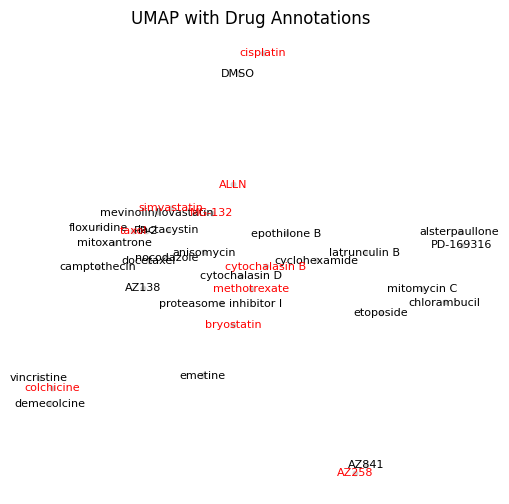

In [48]:
umap_coords = adata.obsm['X_pca']

# Annotation names (drug names) are stored in a specific column of adata.obs
annotation_names = adata.obs['Drug name']  # Replace 'Drug name' with your column name

# Create the UMAP plot
plt.figure(figsize=(6, 6))
plt.scatter(umap_coords[:, 0], umap_coords[:, 1], s=10, c='lightgray')  # Plot the UMAP points

# Annotate the UMAP with drug names
for i, name in enumerate(annotation_names):
    col = "black" if name not in ood_drugs else "red"
    plt.text(umap_coords[i, 0], umap_coords[i, 1], name, fontsize=8, ha='center', va='center', color=col)

# Remove the axes
plt.axis('off')

# Optionally, you can add a title
plt.title('UMAP with Drug Annotations')

# Show the plot
plt.show()


In [41]:
mol2y = {key:val for key, val in dict(zip(bbbc021_index.CPD_NAME,bbbc021_index.ANNOT)).items() }

In [42]:
mol2y

{'ALLN': 'Protein degradation',
 'alsterpaullone': 'Kinase inhibitors',
 'anisomycin': 'Protein synthesis',
 'bryostatin': 'Kinase inhibitors',
 'camptothecin': 'DNA replication',
 'chlorambucil': 'DNA damage',
 'cisplatin': 'DNA damage',
 'colchicine': 'Microtubule destabilizers',
 'cyclohexamide': 'Protein synthesis',
 'cytochalasin B': 'Actin disruptors',
 'cytochalasin D': 'Actin disruptors',
 'demecolcine': 'Microtubule destabilizers',
 'docetaxel': 'Microtubule stabilizers',
 'emetine': 'Protein synthesis',
 'epothilone B': 'Microtubule stabilizers',
 'etoposide': 'DNA damage',
 'floxuridine': 'DNA replication',
 'lactacystin': 'Protein degradation',
 'latrunculin B': 'Actin disruptors',
 'methotrexate': 'DNA replication',
 'mevinolin/lovastatin': 'Cholesterol-lowering',
 'MG-132': 'Protein degradation',
 'mitomycin C': 'DNA damage',
 'mitoxantrone': 'DNA replication',
 'nocodazole': 'Microtubule destabilizers',
 'PD-169316': 'Kinase inhibitors',
 'PP-2': 'Epithelial',
 'proteaso

In [43]:
{'5-fluorouracil': 'Unannotated',
 'acyclovir': 'Unannotated',
 'AG-1478': 'Unannotated',
 'ALLN': 'Protein degradation',
 'aloisine A': 'Unannotated',
 'alsterpaullone': 'Kinase inhibitors',
 'anisomycin': 'Protein synthesis',
 'aphidicolin': 'Unannotated',
 'arabinofuranosylcytosine': 'Unannotated',
 'atropine': 'Unannotated',
 'bleomycin': 'Unannotated',
 'bohemine': 'Unannotated',
 'brefeldin A': 'Unannotated',
 'bryostatin': 'Kinase inhibitors',
 'calpain inhibitor 2 (ALLM)': 'Unannotated',
 'calpeptin': 'Unannotated',
 'camptothecin': 'DNA replication',
 'carboplatin': 'Unannotated',
 'caspase inhibitor 1 (ZVAD)': 'Unannotated',
 'cathepsin inhibitor I': 'Unannotated',
 'Cdk1 inhibitor III': 'Unannotated',
 'Cdk1/2 inhibitor (NU6102)': 'Unannotated',
 'chlorambucil': 'DNA damage',
 'chloramphenicol': 'Unannotated',
 'cisplatin': 'DNA damage',
 'colchicine': 'Microtubule destabilizers',
 'cyclohexamide': 'Protein synthesis',
 'cyclophosphamide': 'Unannotated',
 'cytochalasin B': 'Actin disruptors',
 'cytochalasin D': 'Actin disruptors',
 'demecolcine': 'Microtubule destabilizers',
 'deoxymannojirimycin': 'Unannotated',
 'deoxynojirimycin': 'Unannotated',
 "3,3'-diaminobenzidine": 'Unannotated',
 'docetaxel': 'Microtubule stabilizers',
 'doxorubicin': 'Unannotated',
 'emetine': 'Protein synthesis',
 'epothilone B': 'Microtubule stabilizers',
 'etoposide': 'DNA damage',
 'filipin': 'Unannotated',
 'floxuridine': 'DNA replication',
 'forskolin': 'Unannotated',
 'genistein': 'Unannotated',
 'H-7': 'Unannotated',
 'herbimycin A': 'Unannotated',
 'hydroxyurea': 'Unannotated',
 'ICI-182,780': 'Unannotated',
 'indirubin monoxime': 'Unannotated',
 'jasplakinolide': 'Unannotated',
 'lactacystin': 'Protein degradation',
 'latrunculin B': 'Actin disruptors',
 'leupeptin': 'Unannotated',
 'LY-294002': 'Unannotated',
 'methotrexate': 'DNA replication',
 'methoxylamine': 'Unannotated',
 'mevinolin/lovastatin': 'Cholesterol-lowering',
 'MG-132': 'Protein degradation',
 'mitomycin C': 'DNA damage',
 'mitoxantrone': 'DNA replication',
 'monastrol': 'Unannotated',
 'neomycin': 'Unannotated',
 'nocodazole': 'Microtubule destabilizers',
 'nystatin': 'Unannotated',
 'okadaic acid': 'Unannotated',
 'olomoucine': 'Unannotated',
 'PD-150606': 'Unannotated',
 'PD-169316': 'Kinase inhibitors',
 'PD-98059': 'Unannotated',
 'podophyllotoxin': 'Unannotated',
 'PP-2': 'Epithelial',
 'proteasome inhibitor I': 'Protein degradation',
 'puromycin': 'Unannotated',
 'quercetin': 'Unannotated',
 'raloxifene': 'Unannotated',
 'rapamycin': 'Unannotated',
 'roscovitine': 'Unannotated',
 'SB-202190': 'Unannotated',
 'SB-203580': 'Unannotated',
 'simvastatin': 'Cholesterol-lowering',
 'sodium butyrate': 'Unannotated',
 'sodium fluoride': 'Unannotated',
 'SP-600125': 'Unannotated',
 'staurosporine': 'Unannotated',
 'taurocholate': 'Unannotated',
 'taxol': 'Microtubule stabilizers',
 'temozolomide': 'Unannotated',
 'trichostatin': 'Unannotated',
 'tunicamycin': 'Unannotated',
 'UO-126': 'Unannotated',
 'valproic acid': 'Unannotated',
 'vinblastine': 'Unannotated',
 'vincristine': 'Microtubule destabilizers',
 'Y-27632': 'Unannotated',
 'AZ235': 'Unannotated',
 'AZ138': 'Eg5 inhibitors',
 'AZ701': 'Unannotated',
 'AZ258': 'Aurora kinase inhibitors',
 'AZ841': 'Aurora kinase inhibitors',
 'DMSO': 'DMSO'}

{'5-fluorouracil': 'Unannotated',
 'acyclovir': 'Unannotated',
 'AG-1478': 'Unannotated',
 'ALLN': 'Protein degradation',
 'aloisine A': 'Unannotated',
 'alsterpaullone': 'Kinase inhibitors',
 'anisomycin': 'Protein synthesis',
 'aphidicolin': 'Unannotated',
 'arabinofuranosylcytosine': 'Unannotated',
 'atropine': 'Unannotated',
 'bleomycin': 'Unannotated',
 'bohemine': 'Unannotated',
 'brefeldin A': 'Unannotated',
 'bryostatin': 'Kinase inhibitors',
 'calpain inhibitor 2 (ALLM)': 'Unannotated',
 'calpeptin': 'Unannotated',
 'camptothecin': 'DNA replication',
 'carboplatin': 'Unannotated',
 'caspase inhibitor 1 (ZVAD)': 'Unannotated',
 'cathepsin inhibitor I': 'Unannotated',
 'Cdk1 inhibitor III': 'Unannotated',
 'Cdk1/2 inhibitor (NU6102)': 'Unannotated',
 'chlorambucil': 'DNA damage',
 'chloramphenicol': 'Unannotated',
 'cisplatin': 'DNA damage',
 'colchicine': 'Microtubule destabilizers',
 'cyclohexamide': 'Protein synthesis',
 'cyclophosphamide': 'Unannotated',
 'cytochalasin B': '